## Mount the drive

In [1]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Removing previous trained models

In [2]:
import os

dir_name = '/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/'
test = os.listdir(dir_name)

for item in test:
    if item.endswith('.h5'):
        print(f'deleting {item}')
        os.remove(os.path.join(dir_name, item))

deleting dropconnect_model_epochs_3_num_samples_10.h5


## Imports

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

## Installing keras uncertainty

In [4]:
# keras_uncertainty imports 
# clone and install this library 

!git clone https://github.com/mvaldenegro/keras-uncertainty.git
!pip install --user git+https://github.com/mvaldenegro/keras-uncertainty.git

%cd keras-uncertainty

fatal: destination path 'keras-uncertainty' already exists and is not an empty directory.
  Cloning https://github.com/mvaldenegro/keras-uncertainty.git to /tmp/pip-req-build-ppvf9yvk
  Running command git clone -q https://github.com/mvaldenegro/keras-uncertainty.git /tmp/pip-req-build-ppvf9yvk
/content/keras-uncertainty


## Keras uncertainty specific imports 

In [5]:
import numpy as np 
import tensorflow as tf 
from tensorflow.keras.models import load_model
import random
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input

import keras_uncertainty
#from keras_uncertainty.models import StochasticRegressor, TwoHeadStochasticRegressor
#from keras_uncertainty.models.DeepEnsembleClassifier import DeepEnsemble

#from keras_uncertainty.layers import DropConnectDense, VariationalDense, FlipoutDense, StochasticDropout
from keras_uncertainty.metrics import gaussian_interval_score
from keras_uncertainty.losses import regression_gaussian_nll_loss, regression_gaussian_beta_nll_loss
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True) 

import tensorflow as tf
#tf.compat.v1.disable_eager_execution()

# 28022022 the code works without disabling the eager execution but the standard deviation values are near zero(dont know why) 

# if eager execution is not disabled following error occurs:
# TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), 
#dtype=tf.float32, name=None), name='Placeholder:0', description="created 
#by layer 'tf.cast_4'"), an intermediate Keras symbolic input/output, 
#to a TF API that does not allow registering custom dispatchers, 
#such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. 
#Keras Functional model construction only supports TF API calls that 
#*do* support dispatching, such as `tf.math.add` or `tf.reshape`. 
#Other APIs cannot be called directly on symbolic Kerasinputs/outputs. 
#You can work around this limitation by putting the operation in a custom 
#Keras layer `call` and calling that layer on this symbolic input/output.

Keras Uncertainty will use standalone Keras backend

## Load data

In [6]:
# load the california housing data from csv
train_file = '/content/sample_data/california_housing_train.csv'
test_file = '/content/sample_data/california_housing_test.csv'

train_combined = pd.read_csv(train_file)
test = pd.read_csv(test_file)

# split the data in validation and test (from test.csv)
train, val = train_test_split(train_combined, test_size=0.25)

feature_names = list(train_combined.columns)
print(feature_names)

# assign the target variable
target = 'median_house_value'

# extract the target label in all sets
train_labels_df= train[target]
val_labels_df = val[target]
test_labels_df = test[target]

# extract the data from all sets 
train_data_df = train.drop(columns=target, axis=1)
val_data_df = val.drop(columns=target, axis=1)
test_data_df = test.drop(columns=target, axis=1)

train_data_unnormalized = train_data_df.to_numpy()
train_labels_unnormalized = train_labels_df.to_numpy()

val_data_unnormalized = val_data_df.to_numpy()
val_labels_unnormalized = val_labels_df.to_numpy()

test_data_unnormalized = test_data_df.to_numpy()
test_labels_unnormalized = test_labels_df.to_numpy()

# normalize the data using minmax 
minmax = MinMaxScaler() 

train_data = minmax.fit_transform(train_data_unnormalized)
train_label_temp = np.expand_dims(train_labels_unnormalized, axis=1)
train_labels = minmax.fit_transform(train_label_temp)

val_data = minmax.fit_transform(val_data_unnormalized)
val_label_temp = np.expand_dims(val_labels_unnormalized, axis=1)
val_labels = minmax.fit_transform(val_label_temp)

test_data = minmax.fit_transform(test_data_unnormalized)
test_label_temp = np.expand_dims(test_labels_unnormalized, axis=1)
test_labels = minmax.fit_transform(test_label_temp)


print('Training data shape \n', train_data.shape)
print('Training labels shape \n', train_labels.shape)
#print('Training data \n ', train_data)
#print('Training labels \n ', train_labels)

print('Validation data shape \n ',val_data.shape)
print('Validation labels shape \n ', val_labels.shape)
#print('Validation data \n ', val_data)
#print('Validation labels \n ', val_labels)

print('Test data shape \n ', test_data.shape)
print('Test labels shape \n ', test_labels.shape)
#print('Test data \n ', test_data)
#print('Test labels \n ', test_labels)# load the california housing data from csv

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)


## StochasticModel

In [7]:
import numpy as np
import keras_uncertainty.backend as K

#Layer = K.layers.Layer
#Dropout = K.layers.Dropout


class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10, **kwargs):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=1, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)
            
            
class  StochasticRegressor(StochasticModel):
    def __init__(self, model, num_samples=10, **kwargs):
        # https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers
        super().__init__(model, num_samples)
        self.input = self.model.input
        self.output = self.model.output

    def predict_output(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)
        print('mean_pred ', mean_pred)
        print('std_pred ', std_pred)

        return samples, mean_pred, std_pred 

    def save(self, path):
        # stochaticmodel class does not have basic tf function like save(), summary(), get_layer() and so on 
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        self.model.save(path)

    def summary(self):
        return self.model.summary()  

    def evaluate(self, test_data):
        return self.model.evaluate(test_data)

    def get_layer(self, name=None, index=None):
        # the get_layer() has been taken from ths following source 
        # https://github.com/keras-team/keras/blob/v2.8.0/keras/engine/training.py#L2797-L2831
    
        """Retrieves a layer based on either its name (unique) or index.
        If `name` and `index` are both provided, `index` will take precedence.
        Indices are based on order of horizontal graph traversal (bottom-up).
        Args:
            name: String, name of layer.
            index: Integer, index of layer.
        Returns:
            A layer instance.
        """
        # TODO(fchollet): We could build a dictionary based on layer names
        # since they are constant, but we have not done that yet.
        if index is not None and name is not None:
            raise ValueError('Provide only a layer name or a layer index. Received: '
                        f'index={index}, name={name}.')

        if index is not None:
            if len(self.layers) <= index:
                raise ValueError(f'Was asked to retrieve layer at index {index}'
                            f' but model only has {len(self.layers)}'
                            ' layers.')
            else:
                return self.model.layers[index]

        if name is not None:
            for layer in self.model.layers:
                if layer.name == name:
                    return layer
            raise ValueError(f'No such layer: {name}. Existing layers are: '
                        f'{list(layer.name for layer in self.model.layers)}.')
        raise ValueError('Provide either a layer name or layer index at '
                     '`get_layer`.')

## Dropconnect Layer

In [8]:

import keras_uncertainty.backend as K

Dense = K.layers.Dense
Conv1D = K.layers.Conv1D
Conv2D = K.layers.Conv2D
Conv3D = K.layers.Conv3D

class DropConnect:
    def __init__(self, prob=0.5, drop_bias=False, noise_shape=None):
        self.prob = prob
        self.drop_bias = drop_bias
        self.noise_shape = noise_shape
        self.kernel_noise_shape = None
        self.bias_noise_shape = None

    @property
    def needs_drop(self):
        return 0.0 < self.prob < 1.0

    def replace_tensor(self, tensor_train, tensor_test):
        if self.uses_learning_phase:
            return K.in_train_phase(tensor_train, tensor_test)
        else:
            return tensor_train

    def get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape

        symbolic_shape = K.shape(inputs)
        noise_shape = [symbolic_shape[axis] if shape is None else shape
                       for axis, shape in enumerate(self.noise_shape)]

        return tuple(noise_shape)

    def get_config(self):
        config = {
            "prob": self.prob,
            "drop_bias": self.drop_bias,
            "noise_shape": self.noise_shape
        }

        return config

class DropConnectDense(DropConnect, Dense):
    def __init__(self, units, prob=0.5, drop_bias=False, noise_shape=None, use_learning_phase = False, **kwargs):
        DropConnect.__init__(self, prob=prob, drop_bias=drop_bias, noise_shape=noise_shape)
        Dense.__init__(self, units, **kwargs)

        if self.needs_drop:
            self.uses_learning_phase = use_learning_phase

    def build(self, input_shape):
        Dense.build(self, input_shape)

        if self.needs_drop:
            dc_kernel = K.dropout(self.kernel, self.prob, self.noise_shape)
            self.kernel = self.replace_tensor(dc_kernel, self.kernel)

            if self.drop_bias:
                dc_bias = K.dropout(self.bias, self.prob, self.noise_shape)
                self.bias = self.replace_tensor(dc_bias, self.bias)

    def get_config(self):
        config_dc = DropConnect.get_config(self)
        config_base = Dense.get_config(self)

        return dict(list(config_dc.items()) + list(config_base.items()))


## Define Dropconnect model

Epoch 1/3
399/399 - 3s - loss: 0.0407 - mae: 0.1543 - val_loss: 0.0316 - val_mae: 0.1296 - 3s/epoch - 7ms/step
Epoch 2/3
399/399 - 2s - loss: 0.0295 - mae: 0.1317 - val_loss: 0.0277 - val_mae: 0.1296 - 2s/epoch - 5ms/step
Epoch 3/3
399/399 - 2s - loss: 0.0278 - mae: 0.1271 - val_loss: 0.0273 - val_mae: 0.1306 - 2s/epoch - 6ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 drop_connect_dense (DropCon  (None, 64)               64        
 nectDense)                                                      
                                                                 
 drop_connect_dense_1 (DropC  (None, 64)               64        
 onnectDense)                                                    
                                                                 
 drop_connect_dense_2 (DropC  (None, 64)               64        
 onnectDense)                                        

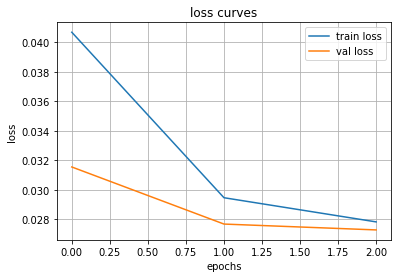

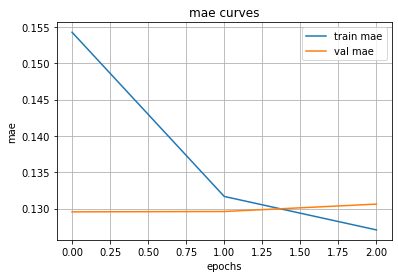

mean_pred  [[0.64993805]
 [0.4287594 ]
 [0.57797533]
 ...
 [0.21046689]
 [0.3391285 ]
 [0.7860685 ]]
std_pred  [[0.        ]
 [0.00000003]
 [0.        ]
 ...
 [0.00000003]
 [0.        ]
 [0.        ]]
pred_samples shape  (10, 3000, 1)
pred_mean shape  (3000, 1)
pred_std shape  (3000, 1)
prediction mean :
 [[0.64993805]
 [0.4287594 ]
 [0.57797533]
 ...
 [0.21046689]
 [0.3391285 ]
 [0.7860685 ]]
prediction mean shape  (3000, 1)
prediction std :
 [[0.        ]
 [0.00000003]
 [0.        ]
 ...
 [0.00000003]
 [0.        ]
 [0.        ]]
prediction std shape  (3000, 1)
prediction samples :
 [[[0.64993805]
  [0.42875937]
  [0.57797533]
  ...
  [0.21046692]
  [0.3391285 ]
  [0.7860685 ]]

 [[0.64993805]
  [0.42875937]
  [0.57797533]
  ...
  [0.21046692]
  [0.3391285 ]
  [0.7860685 ]]

 [[0.64993805]
  [0.42875937]
  [0.57797533]
  ...
  [0.21046692]
  [0.3391285 ]
  [0.7860685 ]]

 ...

 [[0.64993805]
  [0.42875937]
  [0.57797533]
  ...
  [0.21046692]
  [0.3391285 ]
  [0.7860685 ]]

 [[0.64993

In [9]:
# DROPCONNECT MODEL
def train_dropconnect_model(x_train, y_train, x_val, y_val, x_test, epochs, num_samples, prob, noise_shape):
    #obtained from hyperparameter optimization
    K.clear_session()
    model = Sequential()
    model.add(Input(shape=(8, )))
    model.add(DropConnectDense(64, activation='relu', prob=prob, noise_shape=noise_shape))
    model.add(DropConnectDense(64, activation='relu', prob=prob, noise_shape=noise_shape))
    model.add(DropConnectDense(64, activation='relu', prob=prob, noise_shape=noise_shape))
    model.add(DropConnectDense(64, activation='relu', prob=prob, noise_shape=noise_shape))
    model.add(DropConnectDense(64, activation='relu', prob=prob, noise_shape=noise_shape))

    model.add(DropConnectDense(1, activation='relu', noise_shape=noise_shape))

    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

    # train a model with dropconnect() layer
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), verbose=2, epochs=epochs)
    #saving the model that has custom layers
    model.save('/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/dropconnect_model_epochs_'+str(epochs)+'_num_samples_'+str(num_samples)+'.h5') 
    model.summary()

    # plotting the training and validation curves 
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('loss curves')
    plt.show()

    plt.plot(history.history['mae'], label='train mae')
    plt.plot(history.history['val_mae'], label='val mae')
    plt.legend()
    plt.grid()
    plt.xlabel('epochs')
    plt.ylabel('mae')
    plt.title('mae curves')
    plt.show()

    # call the stochasticregressor class and pass the trained model that contains the dropconnect layer 
    mc_model = StochasticRegressor(model)
    pred_samples, pred_mean, pred_std = mc_model.predict_output(x_test, num_samples=num_samples)
    print('pred_samples shape ', pred_samples.shape)
    print('pred_mean shape ', pred_mean.shape)
    print('pred_std shape ', pred_std.shape)

    # return the predicted_samples, predicted_mean, predicted_std and model 
    return pred_samples, pred_mean, pred_std, mc_model

epochs=3
num_samples=10
prob=0.2
noise_shape=None
# running this command creates the stochastic dropconnect model, trains it and generates the predicted_samples, predicted_mean and predicted_std for the test set (all 3000 examples)
prediction_samples, prediction_mean, prediction_std, dropconnect_model = train_dropconnect_model(train_data, train_labels, val_data, val_labels, test_data, epochs=epochs, num_samples=num_samples, prob=prob, noise_shape=noise_shape)
print('prediction mean :\n', prediction_mean)
print('prediction mean shape ', prediction_mean.shape)
print('prediction std :\n', prediction_std)
print('prediction std shape ', prediction_std.shape)
print('prediction samples :\n', prediction_samples)
print('prediction samples shape ', prediction_samples.shape)
print('unique standard deviation values \n', np.unique(prediction_std))

In [10]:
pred_samples, pred_mean, pred_std = dropconnect_model.predict_output(test_data, num_samples=num_samples)
print(pred_samples.shape) 
print(pred_mean.shape)
print(pred_std.shape)

mean_pred  [[0.64993805]
 [0.4287594 ]
 [0.57797533]
 ...
 [0.21046689]
 [0.3391285 ]
 [0.7860685 ]]
std_pred  [[0.        ]
 [0.00000003]
 [0.        ]
 ...
 [0.00000003]
 [0.        ]
 [0.        ]]
(10, 3000, 1)
(3000, 1)
(3000, 1)


indices to be plotted 
 range(1342, 1442)


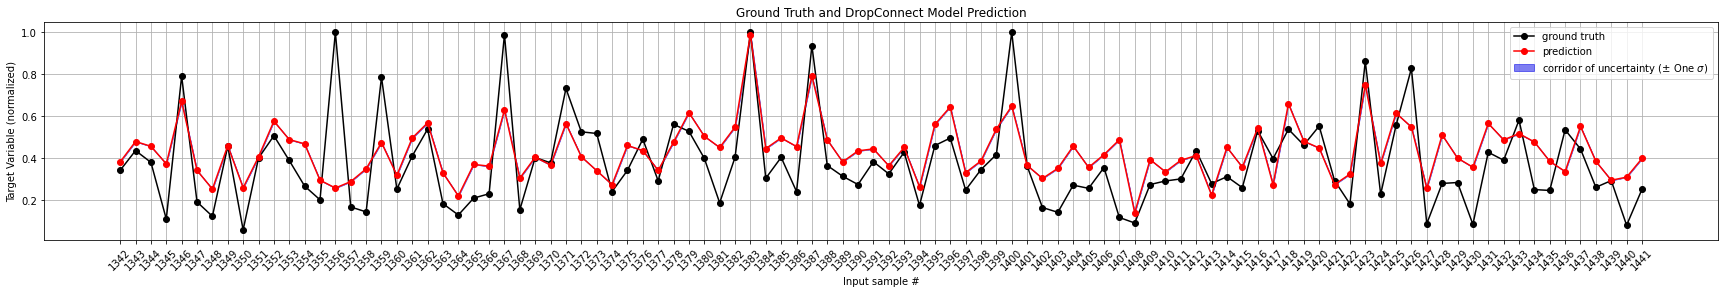

In [11]:
# function to visualize the ground truth with the predicted value and (corridor of uncertainty)

def plot(ground_truth, prediction_mean, prediction_std, path, indices_to_be_plotted):
    plt.figure(figsize=(30, 4))
    plt.plot(range(ground_truth.shape[0]),  ground_truth, color='k', label='ground truth', marker='o')
    plt.plot(range(ground_truth.shape[0]), prediction_mean, color='r', label='prediction', marker='o')
   
    y_pred_mean = prediction_mean.reshape((-1,))
    y_pred_std = prediction_std.reshape((-1,))
    y_pred_up_1 = y_pred_mean + y_pred_std
    y_pred_down_1 = y_pred_mean - y_pred_std

    plt.fill_between(range(ground_truth.shape[0]), y_pred_down_1, y_pred_up_1, color=(0, 0, 0.9, 0.7), label='corridor of uncertainty ($\pm$ One $\sigma$) ', alpha=0.5)
    #plt.plot(range(ground_truth.shape[0]), y_pred_mean, '.', color=(0, 0.9, 0.0, 0.8), markersize=0.2, label='Mean')

    #plt.set_title('{}\nInterval Score: {:.2f}'.format(key, score))
    #plt.set_ylim([-20.0, 20.0])

    #plt.axvline(x=-4.0, color='black', linestyle='dashed')
    #plt.axvline(x= 4.0, color='black', linestyle='dashed')
    #plt.get_xaxis().set_ticks([])
    #plt.get_yaxis().set_ticks([])    

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend()
    plt.grid()
    plt.xticks(range(len(indices_to_be_plotted)), indices_to_be_plotted, rotation=45)
    plt.xlabel('Input sample #')
    plt.ylabel('Target Variable (normalized)')
    plt.title('Ground Truth and DropConnect Model Prediction')
    plt.savefig(path)
    plt.show()

start_index = np.random.randint(test_data.shape[0]-150)
random = range(start_index, start_index+100)
print('indices to be plotted \n', random)
test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
mean_dropconnect_plot = np.asarray([float(pred_mean[i]) for i in random])
std_dropconnect_plot = np.asarray([float(pred_std[i]) for i in random])

plot(test_labels_plot, mean_dropconnect_plot, std_dropconnect_plot, '/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropconnect/output_plots/dropconnect_gt_vs_prediction.pdf', random)